In this lab, you will look at another way of building your text classification model and this will be with a convolution layer. We have seen that convolutions extract features by applying filters to the input. Let's see how you can use that for text data.

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="../data/", download=False)

In [3]:
# Extract the train reviews and labels
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

# Extract the test reviews and labels
test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

In [4]:
# Load vocabulary from the file
with open("imdb_vocab_subwords.txt", "r", encoding="utf-8") as f:
    loaded_vocabulary = [line.strip() for line in f]
    

# Ensure uniqueness again (just in case)
loaded_vocabulary = sorted(set(loaded_vocabulary))


# Ensure required tokens are at the start
if loaded_vocabulary[:2] != ['', '[UNK]']:
    loaded_vocabulary = ['', '[UNK]'] + [word for word in loaded_vocabulary if word not in ['', '[UNK]']]
    
    
# Recreate the TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(vocabulary=loaded_vocabulary)


print(f"Loaded vocabulary size: {len(loaded_vocabulary)}")

Loaded vocabulary size: 121531


In [16]:
# Data pipeline and padding parameters
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 256
MAX_LENGTH = 120
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'


def padding_func(sequences):
    # Putting all the elements in a single ragged bacth
    sequences = sequences.padded_batch(batch_size=tf.data.experimental.cardinality(sequences).numpy(),
                                       padded_shapes=[None])
    
    # Output a tensor from a single batch
    sequences = sequences.get_single_element()
    
    # Pad the sequences
    padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                    maxlen=MAX_LENGTH,
                                                    truncating=TRUNC_TYPE,
                                                    padding=PADDING_TYPE)
    
    # Convert back to tf.data.Dataset
    padded_sequences=tf.data.Dataset.from_tensor_slices(padded_sequences)
    
    return padded_sequences


# Apply the layer to the train and test data
train_sequences_subword = train_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)

In [17]:
train_dataset_vectorized = tf.data.Dataset.zip((train_sequences_subword, train_labels))
test_dataset_vectorized = tf.data.Dataset.zip((test_sequences_subword, test_labels))


# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized.cache()
                      .shuffle(SHUFFLE_BUFFER_SIZE)
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE))

test_dataset_final = (test_dataset_vectorized.cache()
                     .prefetch(PREFETCH_BUFFER_SIZE)
                     .batch(BATCH_SIZE))

In [18]:
# Parameters
BATCH_SIZE = 1
TIMESTEPS = 20
FEATURES = 20
FILTERS = 128
KERNEL_SIZE = 5

print(f'batch_size: {BATCH_SIZE}')
print(f'timesteps (sequence length): {TIMESTEPS}')
print(f'features (embedding size): {FEATURES}')
print(f'filters: {FILTERS}')
print(f'kernel_size: {KERNEL_SIZE}')

# Define array input with random values
random_input = np.random.rand(BATCH_SIZE,TIMESTEPS,FEATURES)
print(f'shape of input array: {random_input.shape}')

# Pass array to convolution layer and inspect output shape
conv1d = tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu')
result = conv1d(random_input)
print(f'shape of conv1d output: {result.shape}')

# Pass array to max pooling layer and inspect output shape
gmp = tf.keras.layers.GlobalMaxPooling1D()
result = gmp(result)
print(f'shape of global max pooling output: {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 20
filters: 128
kernel_size: 5
shape of input array: (1, 20, 20)
shape of conv1d output: (1, 16, 128)
shape of global max pooling output: (1, 128)


In [19]:
# Hyperparameters
EMBEDDING_DIM = 64
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 64

vocab_size = len(vectorize_layer.get_vocabulary())

# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM),
    tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, None, 64)            │       7,777,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, None, 128)           │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,827,393 (29.86 MB)

 Trainable params: 7,827,393 (29.86 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NUM_EPOCHS = 10

# Train the model
history = model.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.5705 - loss: 0.6686 - val_accuracy: 0.7897 - val_loss: 0.4589
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.8375 - loss: 0.3775 - val_accuracy: 0.8151 - val_loss: 0.4049
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9364 - loss: 0.1820 - val_accuracy: 0.8260 - val_loss: 0.4152
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9854 - loss: 0.0611 - val_accuracy: 0.8195 - val_loss: 0.5021
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9988 - loss: 0.0140 - val_accuracy: 0.8185 - val_loss: 0.5798
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9998 - loss: 0.0039 - val_accuracy: 0.8156 - val_loss: 0.6403
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8169 - val_loss: 0.6754
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 1.0000 - loss: 9.0005e-04 - val_accuracy: 0.814

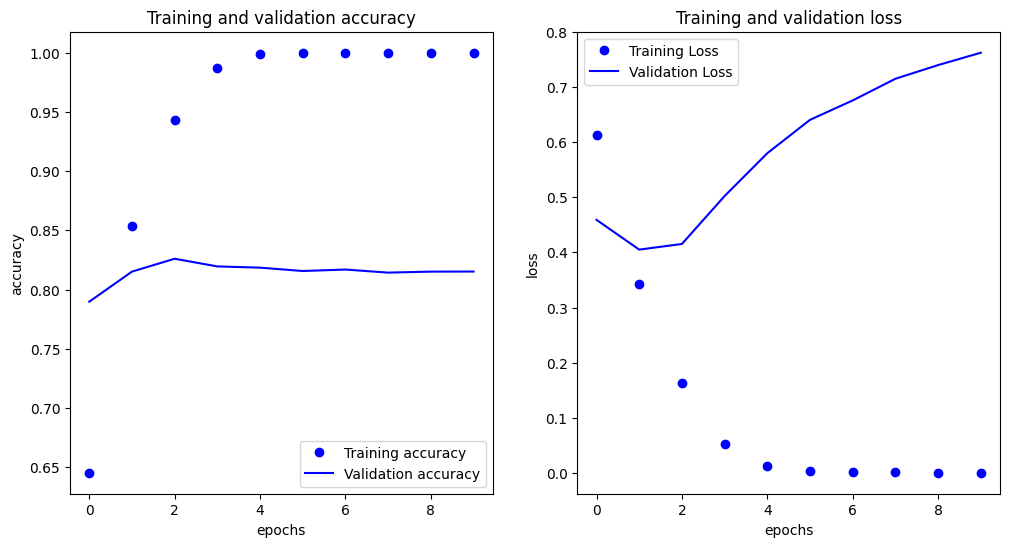

In [21]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)